# Deter Model training



In [175]:
import os
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, "/home/haridas/projects/opensource/detr")
os.environ["CUDA_VISIBLE_DEVICES"] = ""

%matplotlib inline

In [83]:
import torch
import torchvision.transforms as T
from PIL import Image
import datasets
from models.detr import DETR
from models.transformer import build_transformer
from models.backbone import build_backbone
from pathlib import Path

from datasets.coco import make_coco_transforms

In [85]:
# img_transform = make_coco_transforms("val")
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
basedir = Path("/home/haridas/projects/opensource/detr/")

## Strip Trained model for transfer learning

In [54]:
checkpoint = torch.load(f"{basedir}/detr-r50-e632da11.pth", map_location='cpu')

In [57]:
# checkpoint["model"].keys()

In [58]:
# Param sets that needs to be custom learned.
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]
del checkpoint["model"]["query_embed.weight"]

In [59]:
torch.save(checkpoint, f"{basedir}/detr-r50_no-class-head.pth")

## Dataset 

In [4]:
class Args:
    coco_path = "/home/haridas/projects/mystique/data/train_and_test-2020-Jun-05-coco/"
    masks = False
    
train_ds = datasets.custom_coco_build("train", Args)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [15]:
train_ds.coco.cats

{0: {'supercategory': 'none', 'id': 0, 'name': 'actionset'},
 1: {'supercategory': 'none', 'id': 1, 'name': 'checkbox'},
 2: {'supercategory': 'none', 'id': 2, 'name': 'image'},
 3: {'supercategory': 'none', 'id': 3, 'name': 'radiobutton'},
 4: {'supercategory': 'none', 'id': 4, 'name': 'rating'},
 5: {'supercategory': 'none', 'id': 5, 'name': 'textbox'}}

In [180]:
CLASSES = [v["name"] for k, v in train_ds.coco.cats.items()]
CLASSES

['actionset', 'checkbox', 'image', 'radiobutton', 'rating', 'textbox']

## Inference 

In [45]:
model_path = basedir / "outputs" / "checkpoint.pth"

In [17]:
# !ls /home/haridas/projects/opensource/detr/outputs/checkpoint.pth
# !ls /home/haridas/projects/opensource/detr/outputs/checkpooint.pth

In [46]:
state_dict = torch.load(model_path, map_location="cpu")

In [47]:
class DefaultConf:
    backbone = "resnet50"
    position_embedding = "sine"
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    dim_feedforward = 2048
    enc_layers = 6
    dec_layers = 6
    pre_norm = False
    num_queries = 60
    aux_loss = False
    
    # Force to eval model
    lr_backbone = 0
    masks = False
    dilation = False
    device = "cuda"
    
    # Configuration fitting the pic2card specific
    # class configuration.
    dataset_file = "pic2card"
    
backbone = build_backbone(DefaultConf)
transformer_network = build_transformer(DefaultConf)

In [48]:
detr = DETR(backbone=backbone,
            transformer=transformer_network,
            num_queries=60, num_classes=6, aux_loss=False)

In [58]:
detr.load_state_dict(state_dict["model"])
detr.eval();

In [211]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()
    
# plot_results(im, scores, boxes)
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [209]:
img = Image.open("/home/haridas/projects/mystique/data/templates_test_data/mynowassistantcom_App-21.png").convert("RGB")

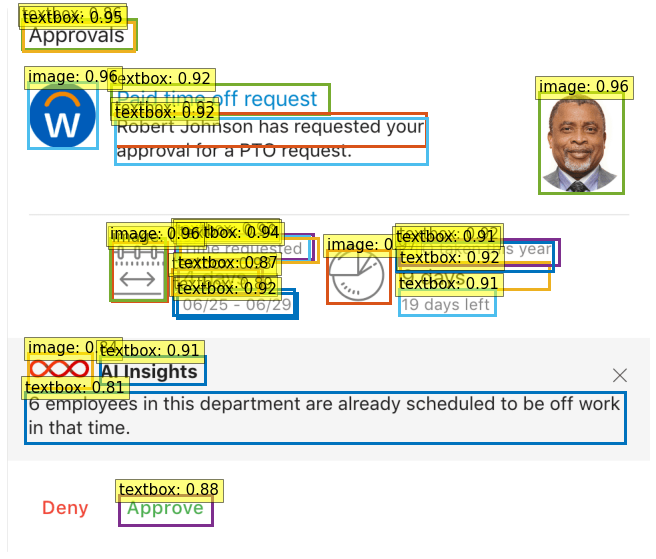

In [212]:
# output['pred_boxes'][-1, keep]
scores, boxes = detect(img, detr, transform)
plot_results(img, scores, boxes)

In [231]:
boxes[:, 0].sort()

torch.return_types.sort(
values=tensor([ 21.5219,  23.3876,  26.0918,  30.2714,  30.5860, 139.3766, 154.2533,
        155.0851, 156.9959, 160.5910, 161.3587, 166.8241, 247.4182, 248.9154,
        251.5849, 253.9563, 254.7376, 255.1784, 258.9556, 478.8808, 582.9956,
        587.6542, 587.7750, 588.4597, 797.7024], grad_fn=<SortBackward>),
indices=tensor([16, 20,  6,  2, 11, 18, 22, 10,  1, 19, 23,  9, 13,  0,  3,  5, 12, 15,
         8,  7, 24, 17, 21, 14,  4]))